# Data Processing 

In [3]:
# Import packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model


### Data Preprocessing 

In the following code block I've taken the pitch and yaw angles from each of the text files and merged them into a singular dataframe with additional columns for a video and frame index. 

In [19]:
# Path to the directory containing the text files
directory = 'labeled'

# List to store the data (video, frame, pitch, yaw)
data = []

# Iterate over all files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        # Extract the video title from the filename (e.g., "video1")
        video_title = filename.split('.')[0]
        
        # Create the full file path
        filepath = os.path.join(directory, filename)
        
        # Open and read the contents of the text file
        with open(filepath, 'r') as file:
            content = file.read().strip()
            
            # Assuming the content contains alternating pitch and yaw values for each frame
            values = list(map(float, content.split()))
            
            # Iterate over the values two at a time (pitch, yaw) and generate frame data
            for i in range(0, len(values), 2):
                frame_number = i // 2  # Frame index
                pitch = values[i]
                yaw = values[i + 1]
                
                # Append a row of data (video title, frame number, pitch, yaw) to the list
                data.append([video_title, frame_number, pitch, yaw])

# Create a DataFrame from the data
df = pd.DataFrame(data, columns=['video', 'frame', 'pitch', 'yaw'])



In [42]:
# Define paths
extracted_frames_dir = 'extracted_frames'
labeled_dir = 'labeled'
unlabeled_dir = 'unlabeled'

# Function to load image paths and corresponding labels
def load_labeled_data(extracted_frames_dir, labeled_dir):
    image_paths = []
    pitches = []
    yaws = []
    
    # Iterate over each labeled video
    for video_id in range(1):  # Videos 0 to 4
        video_folder = f"video_{video_id}"
        video_frames_dir = os.path.join(extracted_frames_dir, video_folder)
        label_file = os.path.join(labeled_dir, f"{video_id}.txt")
        
        if not os.path.exists(label_file):
            print(f"Warning: Label file {label_file} does not exist.")
            continue
        
        # Load labels from the txt file
        labels = np.loadtxt(label_file)
        if labels.ndim == 1:
            labels = labels.reshape(-1, 2)  # Ensure it's a 2D array
        
        # Check number of frames and labels match
        frame_files = sorted([f for f in os.listdir(video_frames_dir) if f.endswith('.jpg')])
        num_frames = len(frame_files)
        num_labels = labels.shape[0]
        
        if num_frames != num_labels:
            print(f"Warning: Number of frames ({num_frames}) and labels ({num_labels}) do not match for video {video_id}.")
            min_length = min(num_frames, num_labels)
            frame_files = frame_files[:min_length]
            labels = labels[:min_length]
        
        # Assign labels to each frame
        for frame_file, (pitch, yaw) in zip(frame_files, labels):
            frame_path = os.path.join(video_frames_dir, frame_file)
            image_paths.append(frame_path)
            pitches.append(pitch)
            yaws.append(yaw)
    
    return np.array(image_paths), np.array(pitches), np.array(yaws)

# Load all labeled data
image_paths, pitches, yaws = load_labeled_data(extracted_frames_dir, labeled_dir)

print(f"Total labeled frames: {len(image_paths)}")

# Optionally, remove frames with NaN labels if any (assuming some labels might be NaN)
valid_indices = ~np.isnan(pitches) & ~np.isnan(yaws)
image_paths = image_paths[valid_indices]
pitches = pitches[valid_indices]
yaws = yaws[valid_indices]

print(f"Total labeled frames after removing NaNs: {len(image_paths)}")


Total labeled frames: 1200
Total labeled frames after removing NaNs: 1200


---

## Feature Extraction 

In [26]:
import numpy as np
import os
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model

# Path where JPEG frames are stored
frames_path = 'extracted_frames/video_0/'

# Load the pre-trained VGG16 model + higher level layers
base_model = VGG16(weights='imagenet')
# Remove the last classification layer, so we only get the feature maps
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

# Function to load and preprocess frames
def load_and_preprocess_image(image_path):
    # Load image and resize to 224x224 as required by VGG16
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    # Add an extra dimension for batch size
    img_array = np.expand_dims(img_array, axis=0)
    # Preprocess the image (mean subtraction, etc.)
    img_array = preprocess_input(img_array)
    return img_array

# Extract features from all frames
def extract_features_from_frames(frames_path):
    frame_files = os.listdir(frames_path)
    features = []
    for file in frame_files:
        image_path = os.path.join(frames_path, file)
        preprocessed_image = load_and_preprocess_image(image_path)
        # Extract features using the pre-trained VGG16 model
        feature = model.predict(preprocessed_image)
        features.append(feature.flatten())  # Flatten the output to 1D
    return np.array(features)

# Example usage
features = extract_features_from_frames(frames_path)

# Save features for later use
np.save('frame_features.npy', features)


1/1 [==============================] - 0s 267ms/step


Feature shape: (1200, 4096)


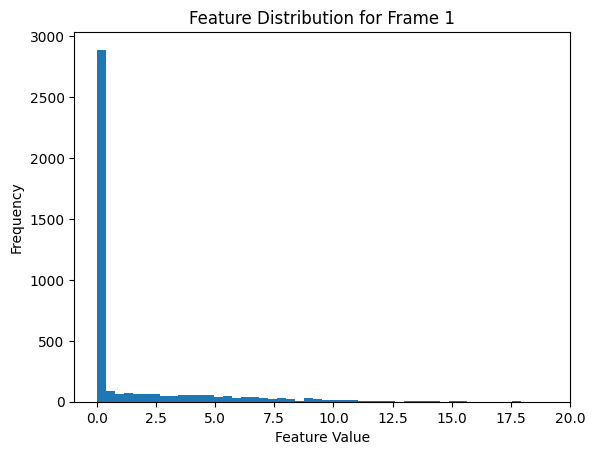

In [30]:
print(f'Feature shape: {features.shape}')  # Example output: (1200, 4096)

# Pick a single frame feature vector (e.g., first frame)
single_frame_feature = features[0]

# Plot histogram of feature values for the first frame
plt.hist(single_frame_feature, bins=50)
plt.title('Feature Distribution for Frame 1')
plt.xlabel('Feature Value')
plt.ylabel('Frequency')
plt.show()


In [63]:
from sklearn.decomposition import PCA

# Perform PCA to reduce to 2 dimensions
pca = PCA(n_components=50)
features_10d = pca.fit_transform(features)
features_10d
print(f'Feature shape: {features_10d.shape}')  # Example output: (1200, 4096)


Feature shape: (1200, 50)


In [59]:
response_data = pd.DataFrame({
    'pitches': pitches, 
    'yaws': yaws
})

# Check the shape of the combined matrix
print(f'Combined matrix shape: {response_data.shape}')

Combined matrix shape: (1200, 2)


Mean Squared Error for Pitch: 1.4326469220962551e-06
Mean Squared Error for Yaw: 2.298790811952389e-06


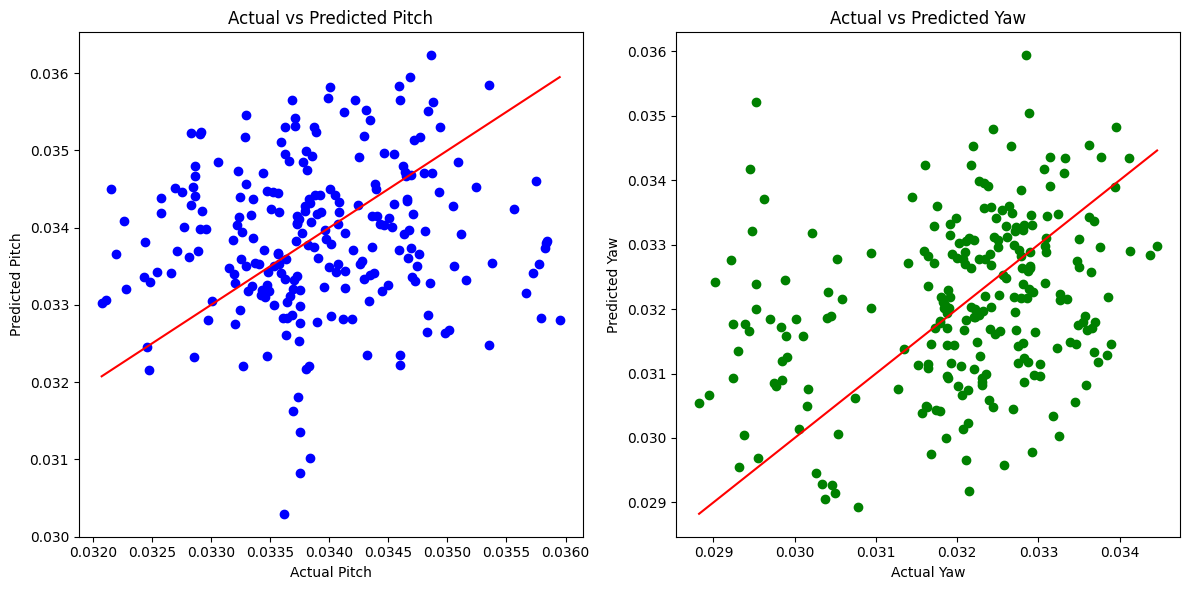

In [70]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Assuming features is a (1200, 10) matrix
# response_data is a dataframe with two columns: 'pitch' and 'yaw' (1200 rows)

# Convert response data to numpy arrays
pitches = response_data['pitches'].values
yaws = response_data['yaws'].values

# Stack pitch and yaw together to form the target matrix (1200, 2)
target = np.column_stack((pitches, yaws))

# Step 1: Train-test split (Optional: can skip this step if you want to train on all data)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Step 2: Train a multi-output linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 3: Make predictions
predictions = model.predict(X_test)

# Step 4: Evaluate the model using mean squared error (MSE) for both pitch and yaw
mse_pitch = mean_squared_error(y_test[:, 0], predictions[:, 0])
mse_yaw = mean_squared_error(y_test[:, 1], predictions[:, 1])

print(f"Mean Squared Error for Pitch: {mse_pitch}")
print(f"Mean Squared Error for Yaw: {mse_yaw}")

# Step 5: Visualize the predictions vs actual for pitch and yaw
plt.figure(figsize=(12, 6))

# Plot for Pitch
plt.subplot(1, 2, 1)
plt.scatter(y_test[:, 0], predictions[:, 0], color='blue', label='Predicted vs Actual Pitch')
plt.plot([min(y_test[:, 0]), max(y_test[:, 0])], [min(y_test[:, 0]), max(y_test[:, 0])], color='red')
plt.xlabel('Actual Pitch')
plt.ylabel('Predicted Pitch')
plt.title('Actual vs Predicted Pitch')

# Plot for Yaw
plt.subplot(1, 2, 2)
plt.scatter(y_test[:, 1], predictions[:, 1], color='green', label='Predicted vs Actual Yaw')
plt.plot([min(y_test[:, 1]), max(y_test[:, 1])], [min(y_test[:, 1]), max(y_test[:, 1])], color='red')
plt.xlabel('Actual Yaw')
plt.ylabel('Predicted Yaw')
plt.title('Actual vs Predicted Yaw')

plt.tight_layout()
plt.show()


Mean Squared Error for Pitch: 6.64184338210399e-07
Mean Squared Error for Yaw: 1.2162195715728323e-06


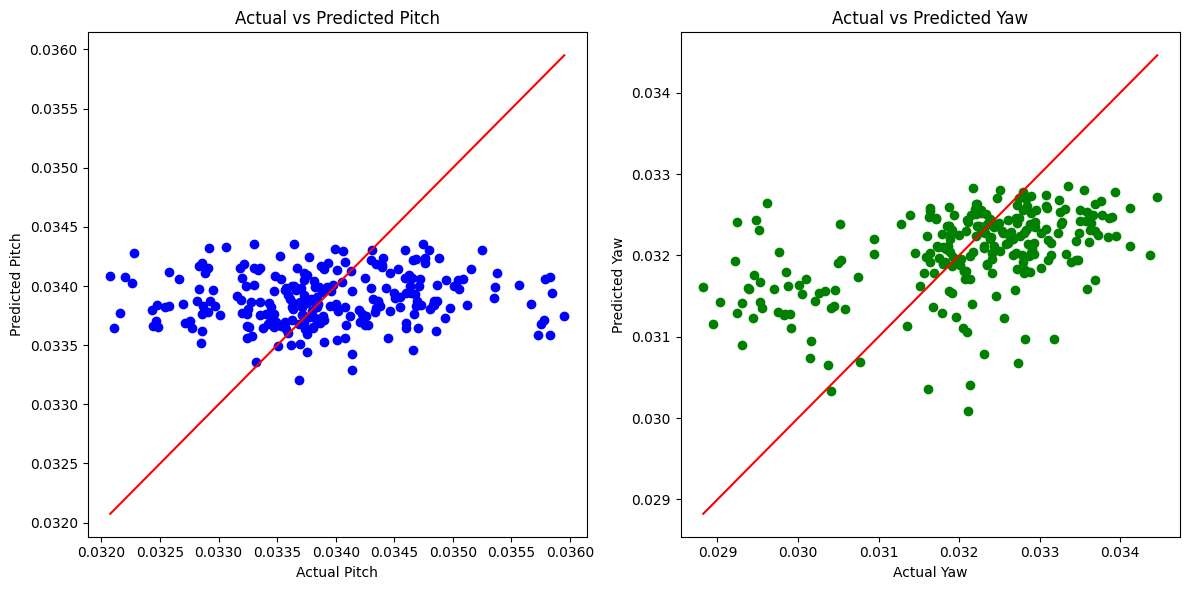

In [82]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import xgboost as xgb
import joblib  # For saving and loading models


# Assuming features is a (1200, 10) matrix
# response_data is a dataframe with two columns: 'pitch' and 'yaw' (1200 rows)

# Convert response data to numpy arrays
pitches = response_data['pitches'].values
yaws = response_data['yaws'].values

# Stack pitch and yaw together to form the target matrix (1200, 2)
target = np.column_stack((pitches, yaws))

# Step 1: Train-test split (Optional: can skip this step if you want to train on all data)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Step 2: Create and train XGBoost models for pitch and yaw separately

# Train XGBoost for pitch prediction
xgb_pitch = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)
xgb_pitch.fit(X_train, y_train[:, 0])

# Train XGBoost for yaw prediction
xgb_yaw = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)
xgb_yaw.fit(X_train, y_train[:, 1])

# Step 3: Make predictions
predicted_pitch = xgb_pitch.predict(X_test)
predicted_yaw = xgb_yaw.predict(X_test)

# Stack predictions together for evaluation
predictions = np.column_stack((predicted_pitch, predicted_yaw))

# Step 4: Evaluate the model using mean squared error (MSE) for both pitch and yaw
mse_pitch = mean_squared_error(y_test[:, 0], predicted_pitch)
mse_yaw = mean_squared_error(y_test[:, 1], predicted_yaw)  # Corrected line

print(f"Mean Squared Error for Pitch: {mse_pitch}")
print(f"Mean Squared Error for Yaw: {mse_yaw}")

# Step 5: Visualize the predictions vs actual for pitch and yaw
plt.figure(figsize=(12, 6))

# Plot for Pitch
plt.subplot(1, 2, 1)
plt.scatter(y_test[:, 0], predicted_pitch, color='blue', label='Predicted vs Actual Pitch')
plt.plot([min(y_test[:, 0]), max(y_test[:, 0])], [min(y_test[:, 0]), max(y_test[:, 0])], color='red')
plt.xlabel('Actual Pitch')
plt.ylabel('Predicted Pitch')
plt.title('Actual vs Predicted Pitch')

# Plot for Yaw
plt.subplot(1, 2, 2)
plt.scatter(y_test[:, 1], predicted_yaw, color='green', label='Predicted vs Actual Yaw')
plt.plot([min(y_test[:, 1]), max(y_test[:, 1])], [min(y_test[:, 1]), max(y_test[:, 1])], color='red')
plt.xlabel('Actual Yaw')
plt.ylabel('Predicted Yaw')
plt.title('Actual vs Predicted Yaw')

plt.tight_layout()
plt.show()


Epoch 1/100
24/24 [==============================] - 3s 17ms/step - loss: 5.2990 - val_loss: 0.1413
Epoch 2/100
24/24 [==============================] - 0s 10ms/step - loss: 0.1756 - val_loss: 0.0586
Epoch 3/100
24/24 [==============================] - 0s 5ms/step - loss: 0.0591 - val_loss: 0.0439
Epoch 4/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0400 - val_loss: 0.0387
Epoch 5/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0309 - val_loss: 0.0301
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - loss: 0.0257 - val_loss: 0.0260
Epoch 7/100
24/24 [==============================] - 0s 5ms/step - loss: 0.0218 - val_loss: 0.0234
Epoch 8/100
24/24 [==============================] - 0s 4ms/step - loss: 0.0184 - val_loss: 0.0219
Epoch 9/100
24/24 [==============================] - 0s 4ms/step - loss: 0.0174 - val_loss: 0.0190
Epoch 10/100
24/24 [==============================] - 0s 4ms/step - loss: 0.0153 - val_loss: 0.0187
Epoch 1

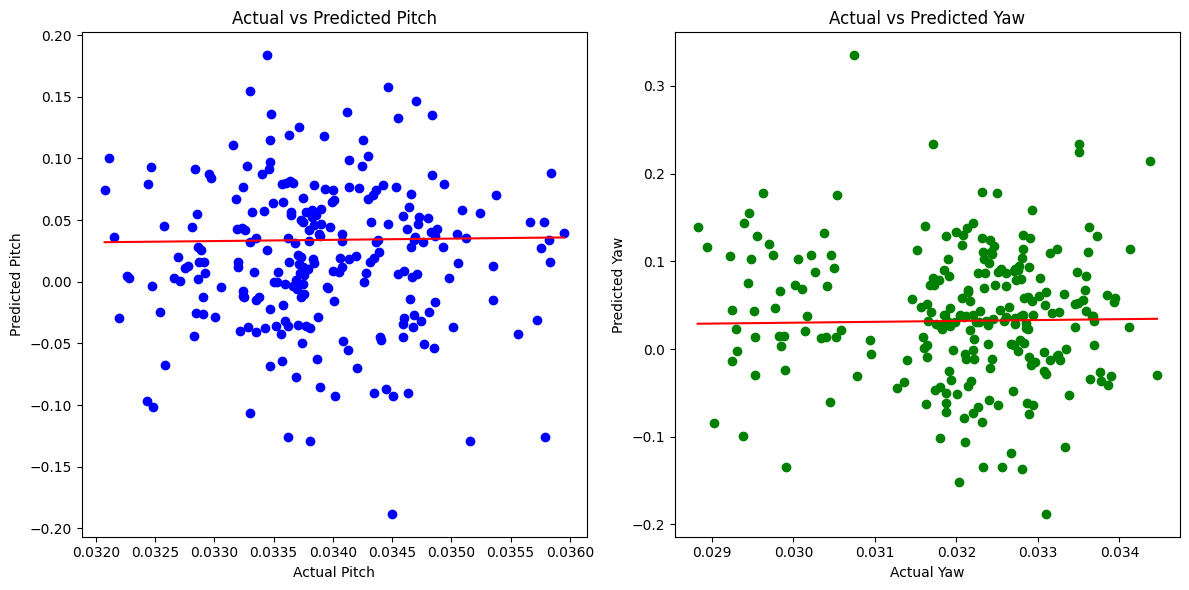

In [76]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

# Assuming features is a (1200, 10) matrix
# response_data is a dataframe with two columns: 'pitch' and 'yaw' (1200 rows)

# Convert response data to numpy arrays
pitches = response_data['pitches'].values
yaws = response_data['yaws'].values

# Stack pitch and yaw together to form the target matrix (1200, 2)
target = np.column_stack((pitches, yaws))

# Step 1: Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Step 2: Build the Neural Network model
model = keras.Sequential()
model.add(layers.Input(shape=(X_train.shape[1],)) )  # Input layer
model.add(layers.Dense(64, activation='relu'))  # Hidden layer 1
model.add(layers.Dense(64, activation='relu'))  # Hidden layer 2
model.add(layers.Dense(2))  # Output layer (2 outputs for pitch and yaw)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 3: Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Step 4: Make predictions
predictions = model.predict(X_test)

# Step 5: Evaluate the model using mean squared error (MSE) for both pitch and yaw
mse_pitch = mean_squared_error(y_test[:, 0], predictions[:, 0])
mse_yaw = mean_squared_error(y_test[:, 1], predictions[:, 1])

print(f"Mean Squared Error for Pitch: {mse_pitch}")
print(f"Mean Squared Error for Yaw: {mse_yaw}")

# Step 6: Visualize the predictions vs actual for pitch and yaw
plt.figure(figsize=(12, 6))

# Plot for Pitch
plt.subplot(1, 2, 1)
plt.scatter(y_test[:, 0], predictions[:, 0], color='blue', label='Predicted vs Actual Pitch')
plt.plot([min(y_test[:, 0]), max(y_test[:, 0])], [min(y_test[:, 0]), max(y_test[:, 0])], color='red')
plt.xlabel('Actual Pitch')
plt.ylabel('Predicted Pitch')
plt.title('Actual vs Predicted Pitch')

# Plot for Yaw
plt.subplot(1, 2, 2)
plt.scatter(y_test[:, 1], predictions[:, 1], color='green', label='Predicted vs Actual Yaw')
plt.plot([min(y_test[:, 1]), max(y_test[:, 1])], [min(y_test[:, 1]), max(y_test[:, 1])], color='red')
plt.xlabel('Actual Yaw')
plt.ylabel('Predicted Yaw')
plt.title('Actual vs Predicted Yaw')

plt.tight_layout()
plt.show()


Mean Squared Error for Pitch: 6.64184338210399e-07
Mean Squared Error for Yaw: 1.2162195715728323e-06


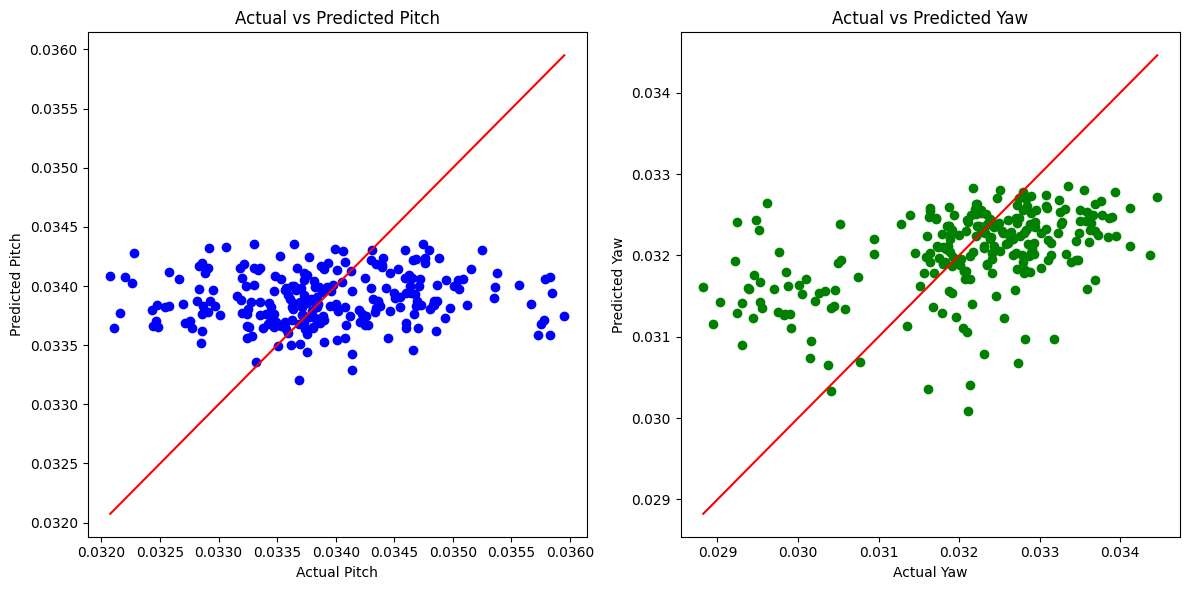

In [83]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import xgboost as xgb
import joblib  # For saving and loading models

# Assuming features is a (1200, 10) matrix
# response_data is a dataframe with two columns: 'pitch' and 'yaw' (1200 rows)

# Convert response data to numpy arrays
pitches = response_data['pitches'].values
yaws = response_data['yaws'].values

# Stack pitch and yaw together to form the target matrix (1200, 2)
target = np.column_stack((pitches, yaws))

# Step 1: Train-test split (Optional: can skip this step if you want to train on all data)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Step 2: Create and train XGBoost models for pitch and yaw separately

# Train XGBoost for pitch prediction
xgb_pitch = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)
xgb_pitch.fit(X_train, y_train[:, 0])

# Train XGBoost for yaw prediction
xgb_yaw = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)
xgb_yaw.fit(X_train, y_train[:, 1])

# Step 3: Save the models to disk
joblib.dump(xgb_pitch, 'xgb_pitch_model.pkl')
joblib.dump(xgb_yaw, 'xgb_yaw_model.pkl')

# Step 4: Make predictions
predicted_pitch = xgb_pitch.predict(X_test)
predicted_yaw = xgb_yaw.predict(X_test)

# Stack predictions together for evaluation
predictions = np.column_stack((predicted_pitch, predicted_yaw))

# Step 5: Evaluate the model using mean squared error (MSE) for both pitch and yaw
mse_pitch = mean_squared_error(y_test[:, 0], predicted_pitch)
mse_yaw = mean_squared_error(y_test[:, 1], predicted_yaw)

print(f"Mean Squared Error for Pitch: {mse_pitch}")
print(f"Mean Squared Error for Yaw: {mse_yaw}")

# Step 6: Visualize the predictions vs actual for pitch and yaw
plt.figure(figsize=(12, 6))

# Plot for Pitch
plt.subplot(1, 2, 1)
plt.scatter(y_test[:, 0], predicted_pitch, color='blue', label='Predicted vs Actual Pitch')
plt.plot([min(y_test[:, 0]), max(y_test[:, 0])], [min(y_test[:, 0]), max(y_test[:, 0])], color='red')
plt.xlabel('Actual Pitch')
plt.ylabel('Predicted Pitch')
plt.title('Actual vs Predicted Pitch')

# Plot for Yaw
plt.subplot(1, 2, 2)
plt.scatter(y_test[:, 1], predicted_yaw, color='green', label='Predicted vs Actual Yaw')
plt.plot([min(y_test[:, 1]), max(y_test[:, 1])], [min(y_test[:, 1]), max(y_test[:, 1])], color='red')
plt.xlabel('Actual Yaw')
plt.ylabel('Predicted Yaw')
plt.title('Actual vs Predicted Yaw')

plt.tight_layout()
plt.show()
